In [2]:
# Data Manipulation and Preprocessing
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Resampling
import time
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# TF-IDF and Dimensionality Reduction
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer

# Modelling
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

# Model Performance
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

# Feature Interpretability
import shap

# Web Interaction and Display
from IPython.display import Image, display, HTML

# Additional JavaScript for toggling code display in Jupyter Notebooks
HTML(
    """
<script src="https://cdnjs.cloudflare.com/ajax/libs/jquery/2.0.3/jquery.min.js "></script>
<script>
code_show=true;
function code_toggle() {
 if (code_show){
 $('div.jp-CodeCell > div.jp-Cell-inputWrapper').hide();
 } else {
 $('div.jp-CodeCell > div.jp-Cell-inputWrapper').show();
 }
 code_show = !code_show
}
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit"
    value="Click here to toggle on/off the raw code."></form>
"""
)

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


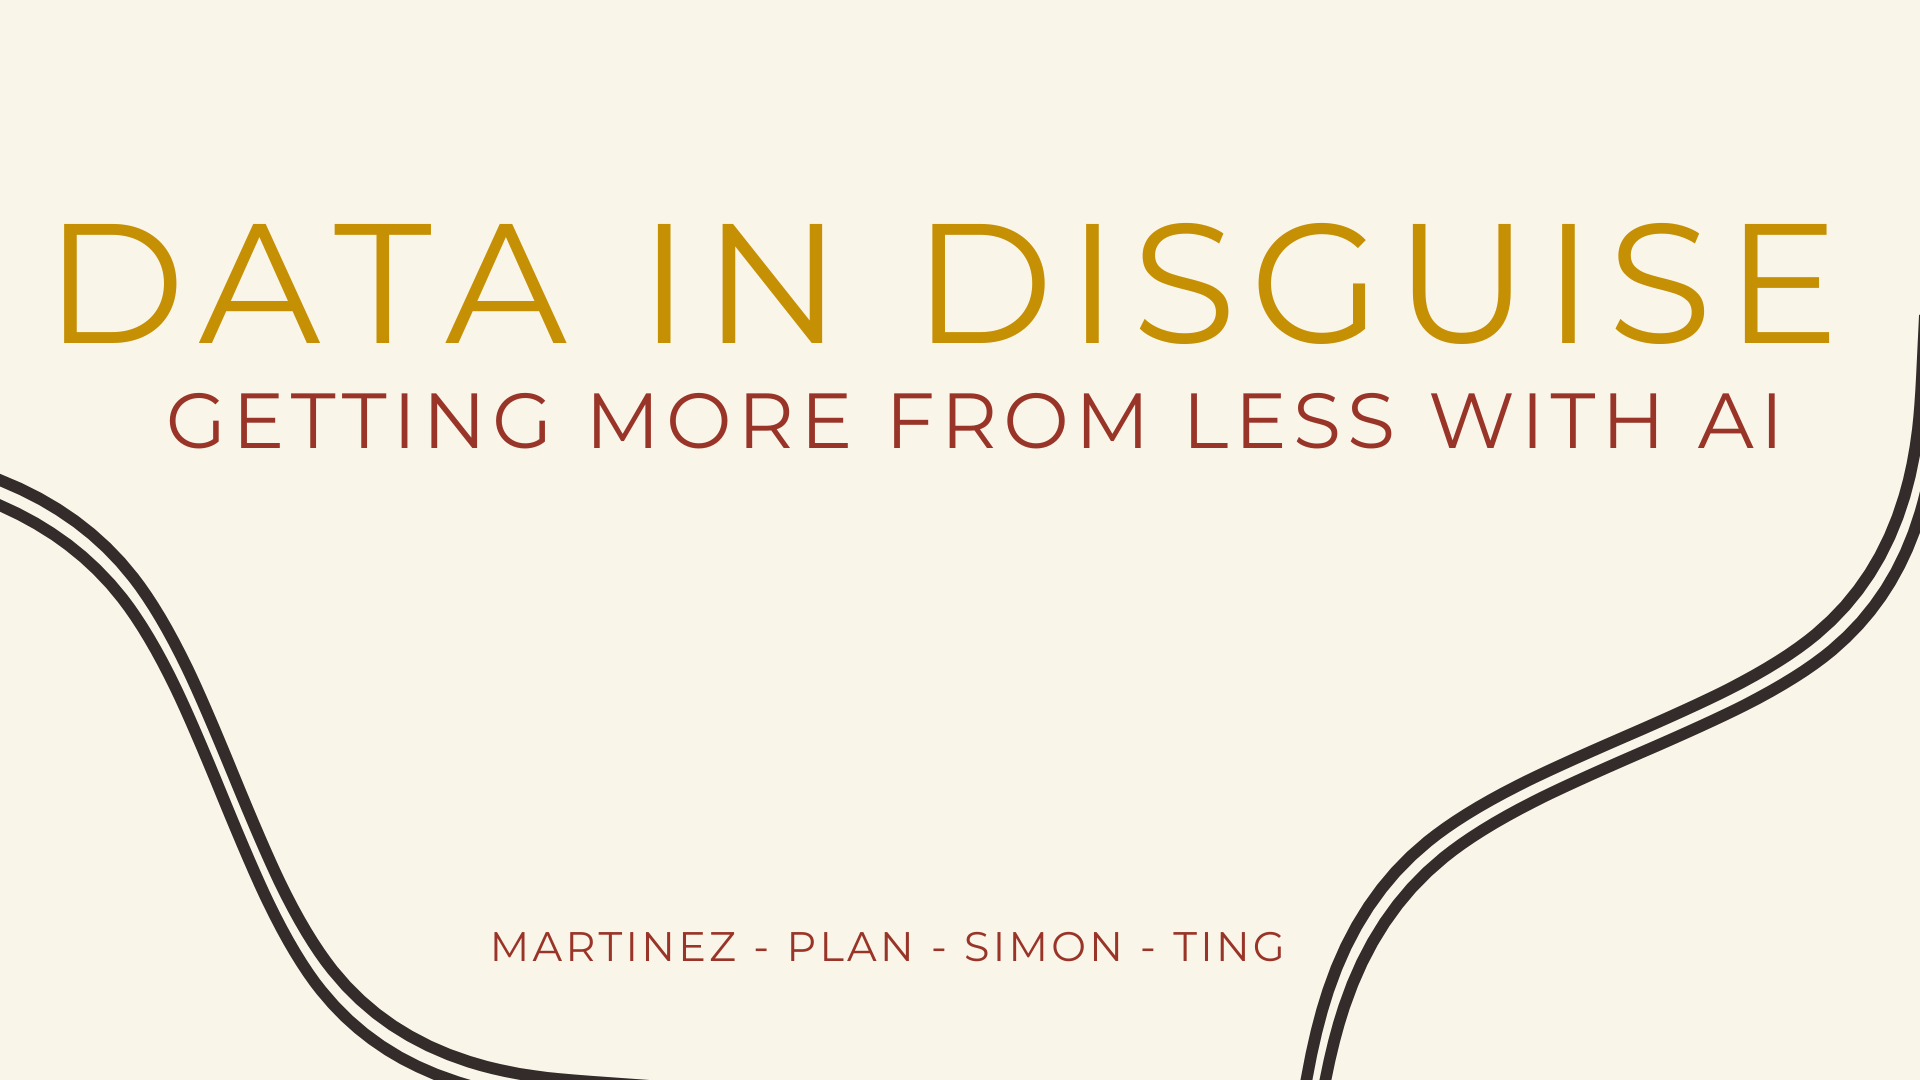

<div style="background-color:#C69004 ; padding: 10px 0;">
    <center><h1 style="color: white; font-weight:bold">DATA AND METHODOLOGY</h1></center>
</div>

<div style="background-color: #AD3A26; padding: 10px 0;">
    <center><h3 style="color: white;font-weight:bold">DATA COLLECTION</h3></center>
</div>

The dataset used in this paper comes from an evaluation framework called TweetEval, a repository consisting of seven heterogeneous Twitter-specific classification tasks, one of which is on emotion recognition. A sample from this dataset is presented in Table 1.

| text                                                                                          | label | emotion |
|-----------------------------------------------------------------------------------------------|-------|---------|
| My roommate: it's okay that we can't spell because we have autocorrect. #terrible #firstworldprobs | 0     | anger   |
| No but that's so cute. Atsu was probably shy about photos before but cherry helped her out uwu | 1     | joy     |
| Rooneys fucking untouchable isn't he? Been fucking dreadful again, depay has looked decent(ish)tonight | 0     | anger   |
| Tiller and breezy should do a collab album. Rapping and singing prolly be fire               | 1     | joy     |
| @user I would never strategically vote for someone I don't agree with. A lot of the Clinton vote based on fear and negativity. | 0     | anger   |

<center><b>Table 1. </b> Emotion Recognition Dataset from <code>TweetEval</code></center>

</br>

While the dataset contains four emotions——<code>anger</code>, <code>joy</code>, <code>sad</code>, <code>optimism</code>——the study only focused on two polar opposite emotional states, <code>anger</code> and <code>joy</code>, to simplify the dataset into a binary classification task. This allows for more generalizable conclusions while still capturing the broad characteristics of emotional expression on Twitter.

<div style="background-color: #AD3A26; padding: 10px 0;">
    <center><h3 style="color: white;font-weight:bold">SUMMARY OF METHODOLOGY PIPELINE</h3></center>
</div>

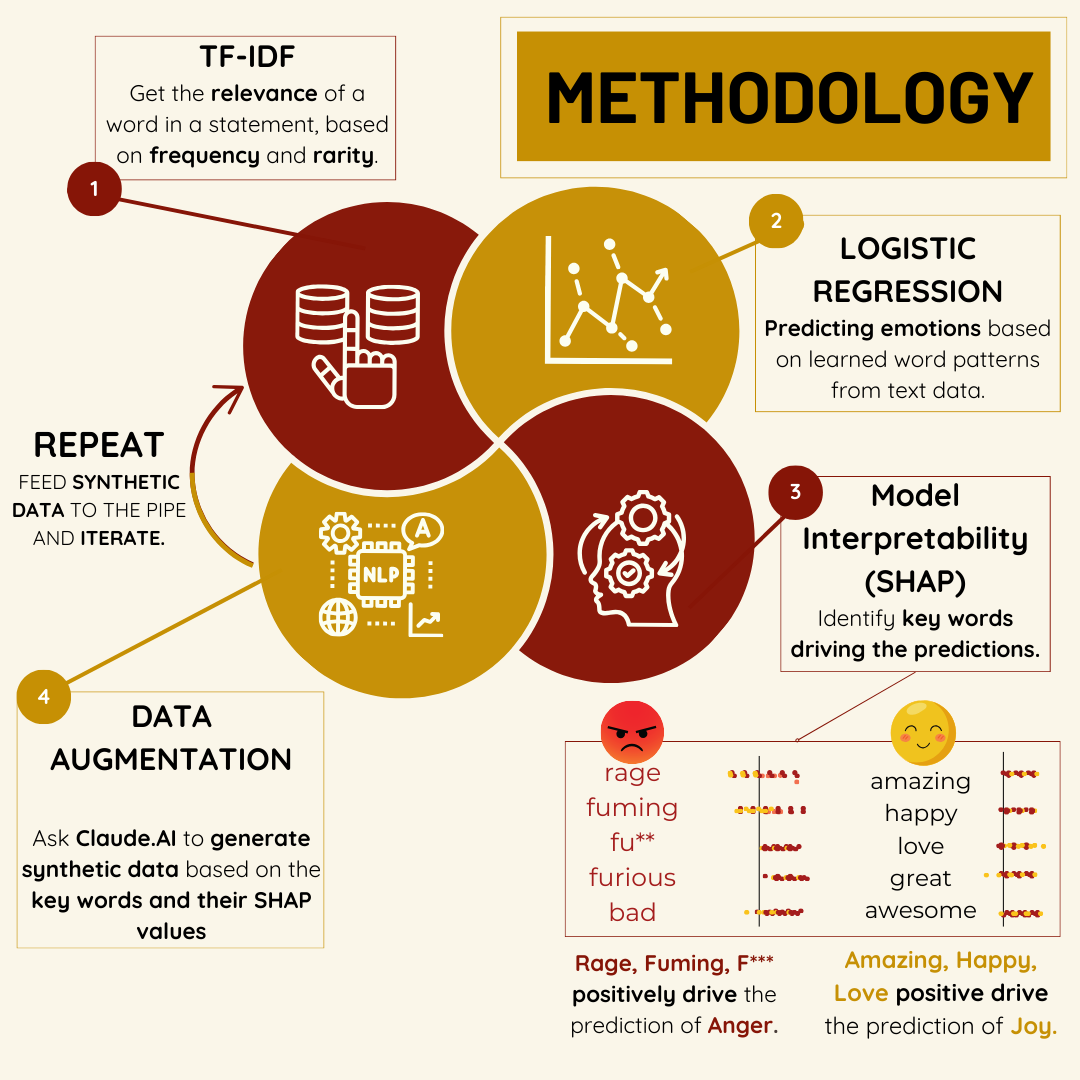

The overall methodology follows a narrative close to that organizations with limited data resources. As such, the steps are as follows: 

1. Data Preprocessing and Partitioning. The original dataset contained 3,281 rows. This subset of 1,000 rows was then extracted and used as the baseline for training and validation of the model. This subset was also the basis for extracting the influential keywords based on interpretability algorithm (SHAP) used. These keywords were then utilized to guide LLMs in generating new, synthetic textual data. An additional 40 rows were used as exemplars to provide guidance to the LLMs. These 1,040 rows were removed from the original dataset, leaving 2,241 rows. This remaining subset was used later for comparing the performance of models trained on synthetic data versus real data. 

2. Model Training. Using the initial 1,000 rows, the authors identified the worst-performing machine learning model for the dataset. The rationale was that if a sub-optimal model could be enhanced through the proposed methodology, the positive results would likely be observable in better-performing models as well. Of the 1,000 rows, 80% was used for training, and 20% was used as a test set. 

3. Obtain Significant Words through SHAP. In addition to providing exemplars to the LLMs, the Shapley Additive Explanations (SHAP) algorithm was used to better inform the generation of synthetic data. Specifically, the top words defining each emotion were fed into the LLMs. 

4. Generate the Synthetic Data. This study utilized Anthropic's Claude.AI and OpenAI's ChatGPT to generate the synthetic textual data. Both LLMs were given the same set of exemplars (20 tweets per emotion) and were asked to generate 500 happy and 500 angry statements, totaling 1,000 AI-generated data points. 

5. Augment the Original Training Data. In this experiment, the performance of the chosen machine learning model was compared when the training set was supplemented with AI-generated data versus real data. The former was the output of the previous step, while the latter was sourced from the remaining pool of real data (2,241 rows) from Step 1. Both types of supplementary data (synthetic and real) were added to the existing training set (800 rows), resulting in augmented training sets of 1,800 rows each. The models trained on these augmented sets were then evaluated to assess the usability of the synthetic data against real data.  


<div style="background-color: #AD3A26; padding: 10px 0;">
    <center><h3 style="color: white;font-weight:bold">Step 1: Data Preprocessing and Partitioning</h3></center>
</div>

The original dataset contained 3,281 rows. It had no missing values and had sufficient balance between the two emotional states—anger and joy—across the entire dataset. While the two classes are not equal in distribution (65% anger, 35% joy), resampling was not applied as the models used could generalize well on their own. 

In [6]:
df = pd.read_csv('all.csv')
df = df[(df.emotion == 'anger') | (df.emotion == 'joy')]

In [ ]:
df.shape

(3281, 3)

This subset of 1,000 rows was then extracted and used as the baseline for training and validation of the model. This subset was also the basis for extracting the influential keywords based on interpretability algorithm (SHAP) used. These keywords were then utilized to guide LLMs in generating new, synthetic textual data. The subset was further divided into 80% for training (800 rows) and 20% for testing (200 rows). An additional 40 rows were set aside from the original dataset and used as exemplars to provide guidance to the LLMs. These 1,040 rows (1,000 + 40) were removed from the original dataset, leaving 2,241 rows. This remaining subset was used later for comparing the performance of models trained on synthetic data versus real data. 

In [7]:
# Only 1000 rows
df_1000 = df.sample(n=1000, random_state=42)

Let's remove the 1000 samples from the full dataset. The purpose of this will be made clearer later.

In [8]:
mask_1000 = ~df.index.isin(df_1000.index)

# Apply the mask to the full dataset
exemplar_pool = df[mask_1000]
exemplar_pool

,text,label,emotion
2,No but that's so cute. Atsu was probably shy a...,1,joy
3,Rooneys fucking untouchable isn't he? Been fuc...,0,anger
5,@user but your pussy was weak from what I hear...,0,anger
7,Tiller and breezy should do a collab album. Ra...,1,joy
8,@user broadband is shocking regretting signing...,0,anger
...,...,...,...
5040,@user @user @user Well that's funny cause we a...,1,joy
5041,@user @user Delusional. Disgraceful. Democra...,0,anger
5043,.@POTUS every other President has said you can...,0,anger
5047,I need a sparkling bodysuit . No occasion. Jus...,1,joy


An additional 40 rows were set aside from the original dataset and used as exemplars to provide guidance to the LLMs. These 1,040 rows (1,000 + 40) were removed from the original dataset, leaving 2,241 rows. This remaining subset was used later for comparing the performance of models trained on synthetic data versus real data.

In [9]:
exemplar_20_anger =  (exemplar_pool[exemplar_pool.emotion == 'anger']
                      .sample(n=20, random_state=42))
exemplar_20_joy = (exemplar_pool[exemplar_pool.emotion == 'joy']
                      .sample(n=20, random_state=42))

mask_exemplars = ~exemplar_pool.index.isin(exemplar_20_anger.index) & ~exemplar_pool.index.isin(exemplar_20_joy.index)
real_data_pool = exemplar_pool[mask_exemplars]

In [ ]:
# exemplar_20_anger.to_csv('20anger.csv', index=False)
# exemplar_20_joy.to_csv('20joy.csv', index=False)

Remove the stopwords in the 1000 samples

In [10]:
def remove_stopwords(text):
    """
    Remove English stopwords from the input text.

    Tokenize the input text into words, filter out stopwords as defined by the
    NLTK library's English stopwords list, and then rejoin the remaining words
    into a single string.

    Parameters
    ----------
    text : str
        A string containing the text from which stopwords need to be removed.

    Returns
    -------
    str
        The text with all English stopwords removed.
    """
    # Set of English stopwords
    stop_words = set(stopwords.words('english'))

    # Tokenize the text
    words = word_tokenize(text)

    # Remove stopwords and rejoin the words
    return ' '.join([word for word in words if word.lower() not in stop_words])

In [11]:
df_1000['text'] = df_1000['text'].apply(remove_stopwords)

<div style="background-color: #AD3A26; padding: 10px 0;">
    <center><h3 style="color: white;font-weight:bold"> EXPLORATORY DATA ANALYSIS</h3></center>
</div>

This section examines the totality of the dataset, focusing more on the distribution of the rows on emotions and as well as checking whether there are null values that need to be removed or taken into consideration.

The dataset has no missing values and has a mild class imbalance based on the distribution of the two emotional states, `anger` and `joy`, across the dataset. Resampling was no longer applied as the machine learning models that were trained could generalize well on their own.

In [ ]:
df_1000.isnull().sum()

text       0
label      0
emotion    0
dtype: int64

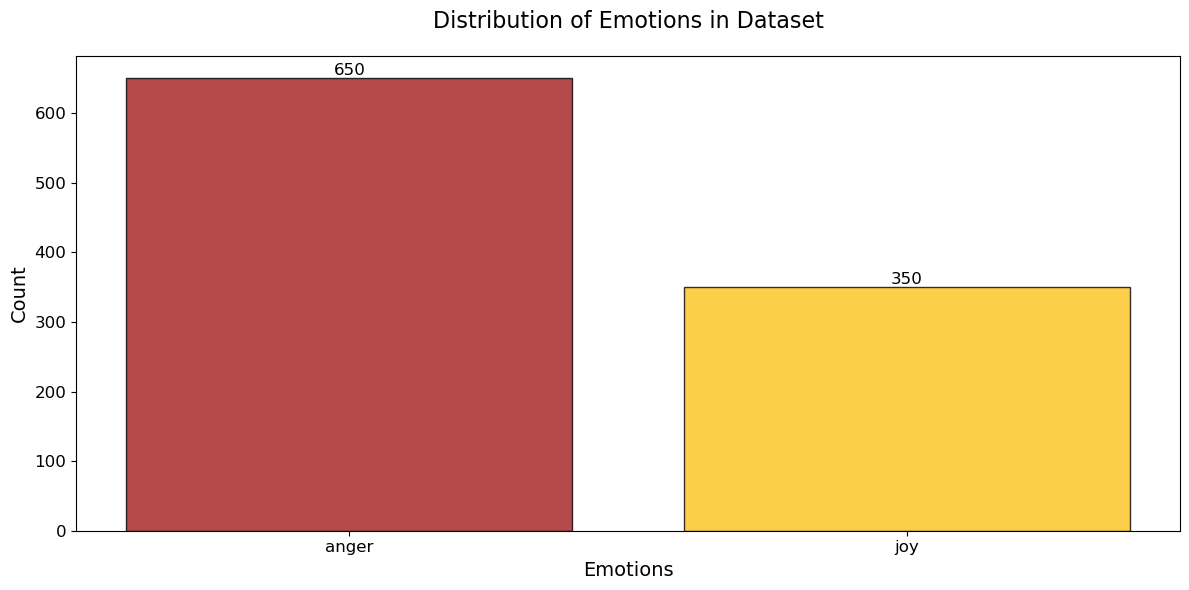

In [ ]:
# Define your custom color palette
custom_colors = ['#A41D1D', '#FAC31C', '#0B63BF']  # Red, Yellow, Blue

# Calculate value counts
emotion_counts = df_1000.emotion.value_counts()

# Create a figure for the plot
fig, ax = plt.subplots(figsize=(12, 6))

# Repeat the custom color palette to match the number of unique emotions
repeated_colors = custom_colors * (len(emotion_counts) // len(custom_colors)) + custom_colors[:len(emotion_counts) % len(custom_colors)]

# Plot the bar chart using the custom color palette
bars = ax.bar(emotion_counts.index, emotion_counts.values,
              color=repeated_colors, edgecolor='black', alpha=0.8)

# Add labels and title
ax.set_xlabel('Emotions', fontsize=14)
ax.set_ylabel('Count', fontsize=14)
ax.set_title('Distribution of Emotions in Dataset', fontsize=16, pad=20)

# Function to add frequency counts on top of the bars
def add_counts_on_bars(ax, bars):
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height, f'{int(height)}',
                ha='center', va='bottom', fontsize=12)

# Add frequency counts on top of the bars
add_counts_on_bars(ax, bars)

# Customize tick parameters for readability
ax.tick_params(axis='both', which='major', labelsize=12)

# Adjust spacing of the plot
plt.tight_layout()

# Show the plot
plt.show()


<div style="background-color: #AD3A26; padding: 10px 0;">
    <center><h3 style="color: white;font-weight:bold">WORD TOKENIZATION AND VECTORIZATION</h3></center>
</div>

The data preprocessing steps included tokenizing each tweet into single words and transforming these words into numerical vectors representing the frequency of each word in the entire corpus of tweets. To highlight words that are distinctive to a particular document, the term frequency-inverse document frequency (TF-IDF) technique was applied to adjust the frequency vectors by how common the words are across all documents. 

In [12]:
# Separate the features (X) and target variable (y)
X = df_1000['text']
y = df_1000['label']

# Generate the 80% training and 20% test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=42)
y_train = y_train.reset_index(drop=True)

In [13]:
original_shape = df_1000.shape[0]
original_train = X_train.shape[0]
original_test = X_test.shape[0]
print("Total number of rows:", original_shape)
print("Number of training:", original_train)
print("Number of test:",original_test)

Total number of rows: 1000
Number of training: 800
Number of test: 200


In [14]:
# Creating the pipeline for word tokenization and vectorization
preprocessing_pipeline = Pipeline([
    ('tfidf',  TfidfVectorizer(token_pattern=r"\b[a-zA-Z']+\b",
                               lowercase=True, min_df=0.001, max_df=0.95,
                               stop_words='english'))
])

In [15]:
X_train_preprocessed = preprocessing_pipeline.fit_transform(X_train)
X_test_preprocessed = preprocessing_pipeline.transform(X_test)

# Print the results
print('Vectorized Training Set:')
print(X_train_preprocessed.toarray(), end='\n\n\n')

print('Vectorized Test Set:')
print(X_test_preprocessed.toarray())

Vectorized Training Set:
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


Vectorized Test Set:
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


<div style="background-color: #AD3A26; padding: 10px 0;">
    <center><h3 style="color: white;font-weight:bold">Step 2: Model Training</h3></center>
</div>

enhanced through the proposed methodology, the positive results would likely be observable in better-performing models as well. The random chance of correctly classifying an instance in this dataset is 54.24%, which translates to an accuracy of 67.80% based on 1.25 times the proportional chance criterion (PCC).  


Furthermore, only the default parameters were used to emphasize the practicality of the proposed methodology for organizations that do not have the capacity to use additional computational resources. Table 2 shows the predictive performance of different classical machine learning models. 


In [16]:
def model_with_crossval(model, X_train_preprocessed, y_train, cv=10):
    train_scores = cross_val_score(model, X_train_preprocessed, y_train, cv=cv)
    test_scores = cross_val_score(model, X_test_preprocessed, y_test, cv=cv)
    train_average_score = np.mean(train_scores)
    test_average_score = np.mean(test_scores)

    return train_average_score, test_average_score

In [17]:
knn_train, knn_test = model_with_crossval(KNeighborsClassifier(),
                                          X_train_preprocessed,
                               y_train, cv=10)
svm_train, svm_test = model_with_crossval(SVC(), X_train_preprocessed, y_train,
                                          cv=10)
lr_train, lr_test = model_with_crossval(LogisticRegression(max_iter=10_000,
                                                  multi_class='ovr'),
                               X_train_preprocessed,
                               y_train, cv=10)
nb_train, nb_test = model_with_crossval(BernoulliNB(), X_train_preprocessed,
                               y_train, cv=10)
rf_train, rf_test = model_with_crossval(RandomForestClassifier(),
                                        X_train_preprocessed,
                               y_train, cv=10)
gbm_train, gbm_test = model_with_crossval(GradientBoostingClassifier(),
                                X_train_preprocessed, y_train, cv=10)
xgb_train, xgb_test = model_with_crossval(XGBClassifier(),
                                          X_train_preprocessed, y_train, cv=10)

# Proportional Chance Criterion
class_count = Counter(df['label'])
df_class = pd.DataFrame.from_dict(class_count, orient='index')

# Calculate the proportions and their squares
num = (df_class[0] / df_class[0].sum())**2

# Calculate Proportion Chance Criterion (PCC)
pcc = num.sum()

In [18]:
models = ['Proportional Chance Criterion (Random Guess)',
          'Logistic Regression',  'K-Nearest Neighbors',
          'Support Vector Machine', 'Random Forest',
          'Gradient Boosting Method', 'Extreme Gradient Boosting Method']
train_scores = [1.25 * pcc, lr_train, knn_train, svm_train, rf_train,
                gbm_train, xgb_train]
# test_scores = [1.25 * pcc, lr_test, knn_test, svm_test, rf_test,
#                 gbm_test, xgb_test]
results = pd.DataFrame({'Model/PCC': models,
                        'Train Accuracy': train_scores})
results.sort_values(by='Train Accuracy', ascending=False)

,Model/PCC,Train Accuracy
2,K-Nearest Neighbors,0.790000
5,Gradient Boosting Method,0.773750
6,Extreme Gradient Boosting Method,0.772500
4,Random Forest,0.762500
1,Logistic Regression,0.715000
3,Support Vector Machine,0.715000
0,Proportional Chance Criterion (Random Guess),0.677951


<center><b>Table 2. </b> Predictive Performance of the Different Classical Machine Learning Models</center

Despite Support Vector Machines (SVM) having the lowest test accuracy, the authors chose to explore Logistic Regression for the following reasons: 

1. Logistic Regression is highly interpretable. It assigns weights to each word, reflecting how strongly associated that word is with the two emotions. This interpretability makes it easier to understand the influence of each word on the emotion prediction. 

2. Logistic Regression is more computationally efficient than SVM. This efficiency emphasizes the practicality of the proposed methodology for organizations with limited computational resources. 

3. Logistic Regression is easier to use compared to SVM. It is straightforward to implement and understand, making it a good choice for a proof-of-concept aimed at organizations that might not have advanced machine learning expertise. 

By choosing the worst-performing yet interpretable and computationally efficient Logistic Regression model, the authors aimed to demonstrate the effectiveness of the proposed methodology in a practical setting with limited resources. In this case, the accuracy to beat is 76%. 

<div style="background-color: #AD3A26; padding: 10px 0;">
    <center><h3 style="color: white;font-weight:bold">Step 3: GENERATE SHAP VALUES BASED ON THE WORST MODEL</h3></center>
</div>

Now that we have chosen our worst model and prepared our dataset, we now start the training our model. Going back with subset 1000 rows data we have discussed earlier, this data will be processed through our pipeline. First, it will be transformed via the initialized TFIDF. Once we have vectorized the data, we can now employ the model. In this study, the LogisticRegression that will be used was not parametrized so that we can full see the effect of the experiemnt given that the model is in its base form. Finally, with this trained model, we can get our baseline accuracy which is the accuracy that to beat with the additional synthetic data in the training set.

In [19]:
X_train_df = pd.DataFrame(X_train_preprocessed.toarray(),
                          columns=(preprocessing_pipeline
                                   .named_steps['tfidf']
                                   .get_feature_names_out()))

X_test_df = pd.DataFrame(X_test_preprocessed.toarray(),
                         columns=(preprocessing_pipeline
                                  .named_steps['tfidf']
                                  .get_feature_names_out()))

The baseline accuracy that the proposed methodology should be able to beat is 76%.

In [20]:
# Create a pipeline with a logistic regression classifier
model_pipeline = Pipeline([
    ('clf', LogisticRegression(max_iter=10_000, multi_class='ovr'))
])

# You can still fit the model on the entire training set if needed
model_pipeline.fit(X_train_df, y_train)

# And evaluate the predictions of the model
y_pred = model_pipeline.predict(X_test_df)
baseline_accuracy = accuracy_score(y_test, y_pred)

print(classification_report(y_test, y_pred))
print("Baseline Accuracy:", baseline_accuracy)


              precision    recall  f1-score   support

           0       0.74      0.98      0.84       132
           1       0.92      0.32      0.48        68

    accuracy                           0.76       200
   macro avg       0.83      0.65      0.66       200
weighted avg       0.80      0.76      0.72       200

Baseline Accuracy: 0.76


Once the model was trained, we can now employ SHAP. Tn this case, the SHAP will explain what are the top contributing words that moved the emotion to become, `joyful` or `angry`. In this study, for the purpose of simplicity and non-computationally taxing experiemnt, we will only let SHAP explains 200 random samples per emotion, the SHAP values that will be generated from the 200 random samples will be the representative contributor for the entire rows of that emotion.

In [ ]:
model = model_pipeline.named_steps['clf']
shap_explainer = shap.Explainer(model.predict_proba, X_train_df)

In [ ]:
emotion_0 = X_train_df[y_train == 0]
emotion_0_200 = emotion_0.sample(n=200)

emotion_1 = X_train_df[y_train == 1]
emotion_1_200 = emotion_1.sample(n=200)

In [ ]:
shap_values_0 = shap_explainer(emotion_0_200,
                               max_evals=2*len(X_train_df.columns)+1)

Permutation explainer: 201it [38:53, 11.67s/it]                         


In [ ]:
shap_values_1 = shap_explainer(emotion_1_200,
                               max_evals=2*len(X_train_df.columns)+1)

Permutation explainer: 201it [38:41, 11.61s/it]                         


<div style="background-color: #AD3A26; padding: 10px 0;">
    <center><h3 style="color: white;font-weight:bold">Step 4: Obtain Significant Words through SHAP</h3></center>
</div>

In addition to providing exemplars to the LLMs, the Shapley Additive Explanations (SHAP) algorithm was used to better inform the generation of synthetic data. Specifically, the top 268 words that were most influential in defining each emotion (anger and joy) were identified and fed into the LLMs. Ideally, all the top words should be extracted, but this number was chosen as a proof of concept. The SHAP algorithm identified words that had a significant contribution and words that had no significant contribution to each emotion. For example, for the amotion anger, words like `fuming`, `hate`, and `love` were identified as having significant contribution, while words like `hilarious`, `birthday`, and `amazing` were identified as having no significant contribution.

It is worth noting that some words might seem counterintuitive to the emotion being considered. For instance, the word ‘love’ had a significant contribution to anger, even though it typically connotes the opposite emotion. This is because the calculation of the top words was based on the mean absolute weight of each word, focusing on the magnitude of the impact that each word has on the model’s predictions without considering the direction of the effect. In other words, the algorithm did not differentiate whether a word pushed the model’s prediction toward joy or anger; it only considered how strongly that word influenced the prediction.

To further refine the list of top words, an additional filtering step was applied based on the average importance of each word for tweets belong to each emotional class (anger or joy). This was done by computing the average term frequency-inverse document frequency (TF-IDF) value of each word for the documents associated with each label, as produced in Section 2.3. If the mean TF-IDF value of a word was greater than 0, it was considered to have a significant effect on the model’s predictions. Otherwise, it was considered insignificant.

The final list of significant words was then used as keywords that the LLMs should consider when generating the synthetic data. Conversely, the LLMs were instructed not to consider the insignificant words.

In [ ]:
feature_names = (preprocessing_pipeline
                 .named_steps['tfidf']
                 .get_feature_names_out())
def weight_emotion(label, shap_values, feature_names):
    """ generates a series of mean absolute value of features as index"""
    shap_values_class_0 = shap_values[:, :, label]
    df = pd.DataFrame(shap_values_class_0[:].values,
                      columns=feature_names)

    return df.abs().mean(axis=0).sort_values(ascending=False)

In [ ]:
# Initialize all the absolute mean weight here
weight_0 = weight_emotion(0, shap_values_0, feature_names)
weight_1 = weight_emotion(1, shap_values_1, feature_names)

In [ ]:
# Calculate the top 20% of feature names
sample_features = 268

list0 = list(weight_0.head(sample_features).index)
list1 = list(weight_1.head(sample_features).index)

In [ ]:
# Initialize the mean of feature of TFIDF per label
emotion_0_mean = emotion_0.mean(axis=0)
emotion_1_mean = emotion_1.mean(axis=0)

In [ ]:
def get_list(list_f, df):
    """Returns the direct and indirect important feature of a label"""
    positive = []
    negative = []
    for column in list_f:
        if df[column] > 0:
            positive.append(column)
        else:
            negative.append(column)
    return positive, negative

In [ ]:
# Initialize all the direct and indirect features here
positive_0, negative_0 = get_list(list0, emotion_0_mean)
positive_1, negative_1 = get_list(list1, emotion_1_mean)


In [ ]:
# Make everything into a dataframe
positive_0_df = pd.DataFrame(positive_0)
positive_1_df = pd.DataFrame(positive_1)

negative_0_df = pd.DataFrame(negative_0)
negative_1_df = pd.DataFrame(negative_1)

In [ ]:
# Save everything in a CSV file
positive_0_df.to_csv('positive_0.csv', index=False)
positive_1_df.to_csv('positive_1.csv', index=False)
negative_0_df.to_csv('negative_0.csv', index=False)
negative_1_df.to_csv('negative_1.csv', index=False)

<div style="background-color: #AD3A26; padding: 10px 0;">
    <center><h3 style="color: white;font-weight:bold">Step 5: GENERATE THE SYNTHETIC DATA</h3></center>
</div>

This study utilized Anthropic's Claude.AI and OpenAI's ChatGPT to generate the synthetic textual data. Both LLMs were given the same set of exemplars (20 tweets per emotion) and were asked to generate 500 happy and 500 angry statements, totaling 1,000 AI-generated data points. 

Below is a sample prompt for generating the synthetic data: 

<i> Hi Claude! I need your help. Can you generate 500 angry statements? This is for my experiment. </i>

<i> Here are some examples: </i>

</i> @user The hatred from the Left ought to concern everyone----who wants a police state-the left, so than can spy on all of us. </i>

 

<i>@user : Whaaaat?!? Oh hell no. I was jealous because you got paid to fuck, but this is a whole new level. #anger #love #conflicted </i>

 

<i>If Monday had a face I would punch it #monday #horrible #face #punch #fight #joke #like #firstworldproblems #need #coffee #asap #follow</i>  

 

… (and so on) 

 

<i>Here are the words that you may consider in your angry statements (note: each word is separated by a space): </i>

<i>hilarious rage fuming fucking furious bad bully people angry</i> … (and so on)</i> 


<div style="background-color: #AD3A26; padding: 10px 0;">
    <center><h3 style="color: white;font-weight:bold">Step 6: AUGMENT THE ORIGNIAL TRAINING DATA</h3></center>
</div>

In this experiment, the performance of the chosen machine learning model (Logistic Regressin) was compared when the training set was augmented with two different types of data: AI-generated synthetic data and real. The synthetic data was the output from the previous step, where LLMs generated 1,000 new data points. The real data was sourced from the remaining pool of 2,241 rows from Step 1 (the original dataset after removing the 1,040 rows used for training, testing, and exemplars). 

Both types of supplementary data (synthetic and real) were added to the existing training set of 800 rows at an interval of 5% of the total supplementary data size. For example, at the first interval, 50 synthetic data points (5% of 1,000) were added to the original 800 training rows, creating an augmented training set of 850 rows. Similarly, 50 real data points (5% of 1,000) were added to the original 800 training rows, creating a separate augmented training set of 850 rows. This process was repeated at intervals of 5% until all 1,000 supplementary data points (synthetic or real) were added to the original training set, resulting in augmented training sets of 1,800 rows each. Figure X and Figure X+1 illustrate this process. 

In [21]:
df_angry = pd.read_csv('500-angry.csv')
df_joy = pd.read_csv('500-joy.csv')

Add all the synthetic data to `X_train`.

In [23]:
all_synthetic = pd.concat([df_angry, df_joy], ignore_index=True)

<div style="background-color: #AD3A26; padding: 10px 0;">
    <center><h3 style="color: white;font-weight:bold">8. Compare the results of Adding Real Data</h3></center>
</div>

Get 1000 rows from the remaining dataframe after the exemplars and the sampled 1000 were removed. This is the resulting dataframe:

In [24]:
df_actual_1000 = real_data_pool.sample(n=1000, random_state=42)
df_actual_1000

,text,label,emotion
1852,"@user stop the presses, @user said/proposed so...",0,anger
2107,@user horrible service. EWR. Not a cloud in th...,0,anger
3465,"Beware the wrath of an angry, frustrated, #agi...",0,anger
560,Being forced into a fake hug by someone who di...,0,anger
4300,It's irrelevant having a skinny body when you ...,0,anger
...,...,...,...
5043,.@POTUS every other President has said you can...,0,anger
4023,Attention seeker Chris Uhlmann highly aroused ...,1,joy
1210,Shoutout to @user for ruining my iPhone 7 orde...,0,anger
181,Good morning chirpy #SpringEquinox and your pe...,1,joy


Remove these rows from the original dataframe. We will use that for getting different test sets.

In [25]:
mask_1000_actual = ~real_data_pool.index.isin(df_actual_1000.index)
test_pool = real_data_pool[mask_1000_actual]

### Choosing different test sets from `test_pool`.

In [26]:
def train_and_evaluate(X_train, y_train, X_train_df, X_test_df,
                       y_test, print_results=True):
    # Dictionary to store accuracies for each fraction
    accuracies_per_frac_synthetic = {round(i, 2): [] for i in np.arange(0.0, 1.05, 0.05)}
    adds_to_train_synthetic = []
    
    accuracies_per_frac_real = {round(i, 2): [] for i in np.arange(0.0, 1.05, 0.05)}
    adds_to_train_real = []
    
    # Initial accuracy without supplementary data
    model_pipeline.fit(X_train_df, y_train)
    y_pred = model_pipeline.predict(X_test_df)
    baseline_accuracy = accuracy_score(y_test, y_pred)
    
    accuracies_per_frac_synthetic[0.0].append(baseline_accuracy)
    accuracies_per_frac_real[0.0].append(baseline_accuracy)
    # print(accuracies_per_frac_synthetic)
    # print(accuracies_per_frac_real)
    for test_set in range(10):
        for i in np.arange(0.05, 1.05, 0.05):
            i = round(i, 2)
            # All synthetic
            add_to_train_synth = (all_synthetic
                                  .sample(frac=i, random_state=42)
                                  .reset_index(drop=True))
            new_X_train_synth = pd.concat([X_train, add_to_train_synth['text']], 
                                    ignore_index=True)
            new_y_train_synth = pd.concat([y_train, add_to_train_synth['label']],
                                    ignore_index=True)

            new_X_train_preprocessed_synth = (preprocessing_pipeline
                                        .fit_transform(new_X_train_synth))
            new_test_synth = test_pool.sample(n=200)
            new_X_test_synth = new_test_synth['text']
            new_y_test_synth = new_test_synth['label']
            new_X_test_preprocessed_synth = (preprocessing_pipeline
                                       .transform(new_X_test_synth))

            model_pipeline.fit(new_X_train_preprocessed_synth, 
                               new_y_train_synth)
            y_pred_synth = model_pipeline.predict(new_X_test_preprocessed_synth)
            accuracy_synth = accuracy_score(new_y_test_synth, y_pred_synth)
            
            ### Store the accuracy for this fraction
            accuracies_per_frac_synthetic[i].append(accuracy_synth)
            
            # All real
            add_to_train_real = (df_actual_1000
                                  .sample(frac=i, random_state=42)
                                  .reset_index(drop=True))
            new_X_train_real = pd.concat([X_train, add_to_train_real['text']], 
                                    ignore_index=True)
            new_y_train_real = pd.concat([y_train, add_to_train_real['label']],
                                    ignore_index=True)

            new_X_train_preprocessed_real = (preprocessing_pipeline
                                             .fit_transform(new_X_train_real))
            new_test_real = test_pool.sample(n=200)
            new_X_test_real = new_test_real['text']
            new_y_test_real = new_test_real['label']
            new_X_test_preprocessed_real = (preprocessing_pipeline
                                            .transform(new_X_test_real))

            model_pipeline.fit(new_X_train_preprocessed_real, 
                               new_y_train_real)
            y_pred_real = model_pipeline.predict(new_X_test_preprocessed_real)
            accuracy_real = accuracy_score(new_y_test_real, y_pred_real)
            
            # Store the accuracy for this fraction
            accuracies_per_frac_real[i].append(accuracy_real)

        adds_to_train_synthetic.append(add_to_train_synth.shape[0])
        adds_to_train_real.append(add_to_train_real.shape[0])

    # Calculate the mean accuracy for every fraction
    mean_accuracies_synth = {i: np.mean(accuracies) for i, 
                       accuracies in accuracies_per_frac_synthetic.items()}
    std_accuracies_synth = {i: np.std(accuracies) for i, 
                       accuracies in accuracies_per_frac_synthetic.items()}
    
    mean_accuracies_real = {i: np.mean(accuracies) for i, 
                       accuracies in accuracies_per_frac_real.items()}
    std_accuracies_real = {i: np.std(accuracies) for i, 
                       accuracies in accuracies_per_frac_real.items()}

    if print_results:
        for i in np.arange(0.0, 1.05, 0.05):
            i = round(i, 2)
            print(f"{i*100:.2f}% of Supplementary Data Added")
            print(f"\tReal Data: New Accuracy: {mean_accuracies_real[i]:.6f}")
            print(f"\tSynthetic Data: New Accuracy: {mean_accuracies_synth[i]:.6f}")

    return mean_accuracies_synth, std_accuracies_synth, adds_to_train_synthetic, mean_accuracies_real, std_accuracies_real

In [27]:
(mean_accuracies_synth, 
 std_accuracies_synth, 
 additions, 
 mean_accuracies_real, 
 std_accuracies_real) = train_and_evaluate(X_train, y_train, X_train_df, 
                                           X_test_df, y_test, 
                                           print_results=True)

0.00% of Supplementary Data Added
	Real Data: New Accuracy: 0.760000
	Synthetic Data: New Accuracy: 0.760000
5.00% of Supplementary Data Added
	Real Data: New Accuracy: 0.721500
	Synthetic Data: New Accuracy: 0.748000
10.00% of Supplementary Data Added
	Real Data: New Accuracy: 0.735500
	Synthetic Data: New Accuracy: 0.724500
15.00% of Supplementary Data Added
	Real Data: New Accuracy: 0.729000
	Synthetic Data: New Accuracy: 0.763500
20.00% of Supplementary Data Added
	Real Data: New Accuracy: 0.721000
	Synthetic Data: New Accuracy: 0.777000
25.00% of Supplementary Data Added
	Real Data: New Accuracy: 0.740500
	Synthetic Data: New Accuracy: 0.788500
30.00% of Supplementary Data Added
	Real Data: New Accuracy: 0.774500
	Synthetic Data: New Accuracy: 0.773500
35.00% of Supplementary Data Added
	Real Data: New Accuracy: 0.762500
	Synthetic Data: New Accuracy: 0.784000
40.00% of Supplementary Data Added
	Real Data: New Accuracy: 0.789000
	Synthetic Data: New Accuracy: 0.779000
45.00% of Su

<div style="background-color:#C69004 ; padding: 10px 0;">
    <center><h1 style="color: white; font-weight:bold">RESULTS</h1></center>
</div>

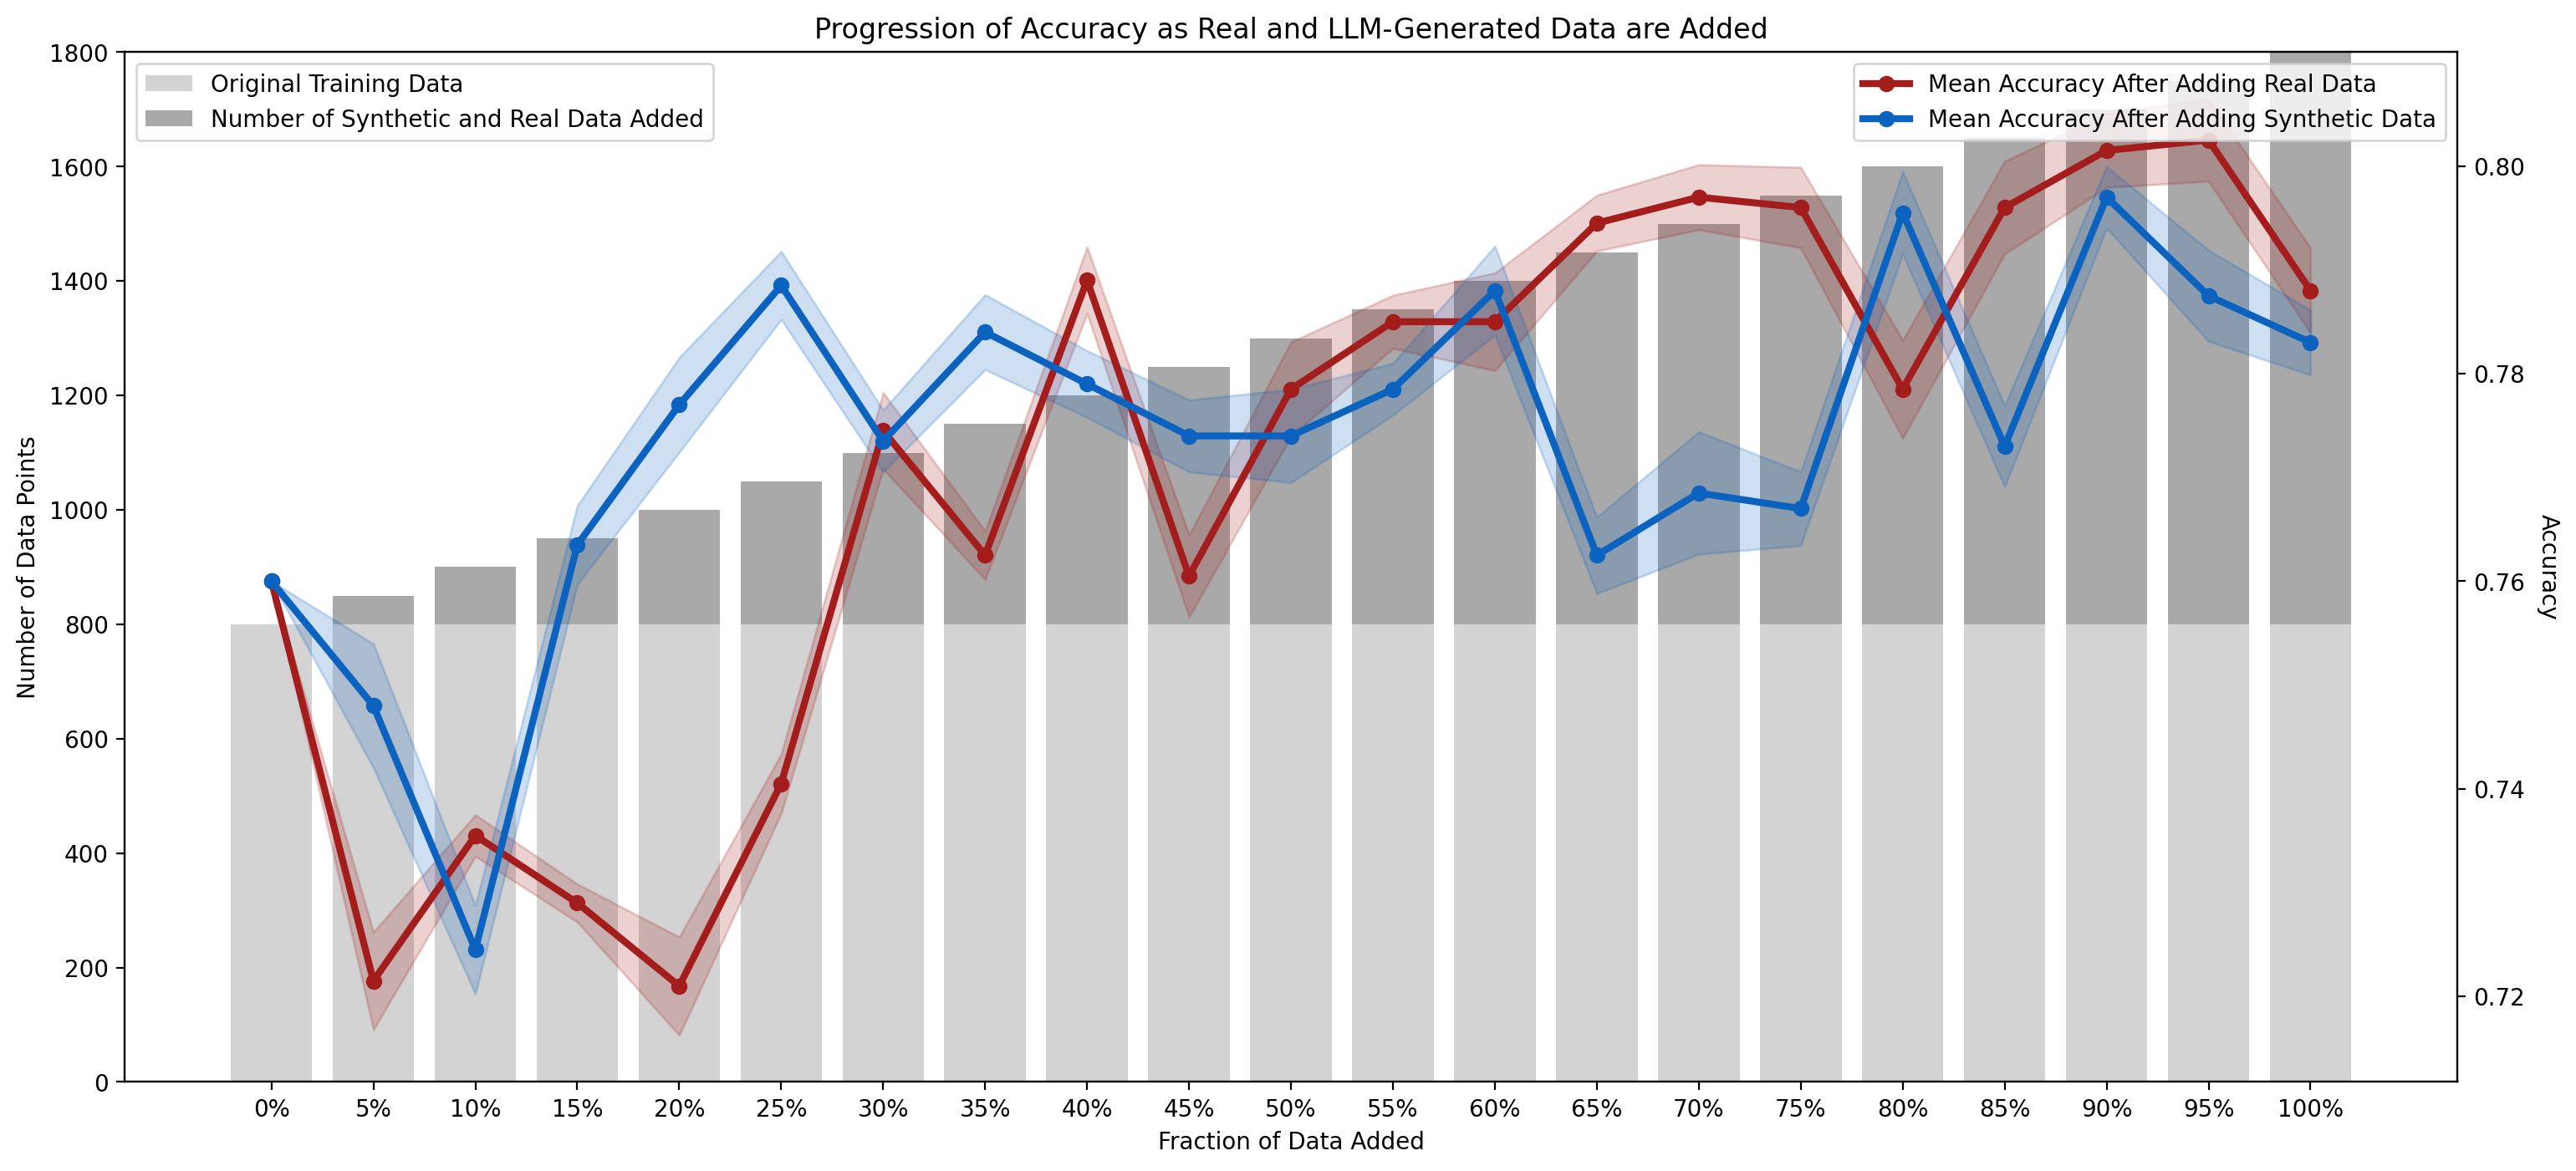

In [28]:
original_train = 800
data_points_added = [int(len(df_actual_1000) * i) for i in np.arange(0.0, 
                                                                     1.05, 
                                                                     0.05)]

# Convert lists to numpy arrays for element-wise operations
mean_reals = np.array(list(mean_accuracies_real.values()))
std_dev_reals = np.array(list(std_accuracies_real.values()))
mean_synths = np.array(list(mean_accuracies_synth.values()))
std_dev_synths = np.array(list(std_accuracies_synth.values()))

# Scale down the standard deviations
scale_factor = 0.15
scaled_std_dev_reals = std_dev_reals * scale_factor
scaled_std_dev_synths = std_dev_synths * scale_factor

categories = np.arange(len(mean_synths))

fig, ax1 = plt.subplots(figsize=(18, 8), dpi=200)
ax1.bar(categories, [original_train]*len(mean_reals),
        label='Original Training Data', color='lightgrey')
ax1.bar(categories, data_points_added, bottom=[original_train]*len(mean_synths),
        label='Number of Synthetic and Real Data Added', color='darkgrey')

ax1.set_xlabel('Fraction of Data Added')
ax1.set_ylabel('Number of Data Points')
ax1.set_xticks(categories)
ax1.set_xticklabels([f'{i*100:.0f}%' for i in np.arange(0.0, 1.05, 0.05)])
ax1.legend(loc='upper left')
ax1.set_ylim(0, max(data_points_added) + original_train)

ax2 = ax1.twinx()
ax2.fill_between(categories, mean_reals + scaled_std_dev_reals,
                 mean_reals - scaled_std_dev_reals,
                 color='#A41D1D', alpha=0.2)
ax2.fill_between(categories, mean_synths + scaled_std_dev_synths,
                 mean_synths - scaled_std_dev_synths,
                 color='#0B63BF', alpha=0.2)

ax2.plot(categories, mean_reals, lw=3, marker='o',
         label="Mean Accuracy After Adding Real Data",
         color='#A41D1D')
ax2.plot(categories, mean_synths, lw=3, marker='o',
         label="Mean Accuracy After Adding Synthetic Data",
         color='#0B63BF')

ax2.set_ylabel('Accuracy', labelpad=15)
ax2.get_yaxis().get_label().set_rotation(270)
ax2.legend(loc='upper right')

plt.title('Progression of Accuracy as Real and LLM-Generated Data are Added')

plt.show()
